In [3]:
import os
from glob import glob
from tqdm import tqdm
from abraia.inference.clip import Clip
from abraia.inference.ops import cosine_similarity
from abraia.utils import dataset, load_image, image_base64

clip_model = Clip()

output_dir = '../vineyard'
search_query = "vineyard leaves"
# dataset.download(search_query, limit=200, output_dir=output_dir)

image_paths = glob(os.path.join(output_dir, '*.jpg'))
image_embeddings = [clip_model.get_image_embeddings([load_image(image_path)])[0] for image_path in tqdm(image_paths)]

2025-04-19 15:08:51.416775 [W:onnxruntime:, coreml_execution_provider.cc:107 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 6 number of nodes in the graph: 889 number of nodes supported by CoreML: 30
2025-04-19 15:08:53.241011 [W:onnxruntime:, helper.cc:82 IsInputSupported] CoreML does not support input dim > 16384. Input:token_embedding.weight, shape: {49408,512}
2025-04-19 15:08:53.241202 [W:onnxruntime:, coreml_execution_provider.cc:107 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 4 number of nodes in the graph: 910 number of nodes supported by CoreML: 18
100%|██████████| 353/353 [00:19<00:00, 18.57it/s]


,path1,path2,similarity,image1,image2
156,../vineyard/image_193.jpg,../vineyard/image_280.jpg,0.965754,,
2480,../vineyard/Image_151 (1).jpg,../vineyard/Image_136.jpg,0.961597,,
6295,../vineyard/image_28.jpg,../vineyard/Image_76.jpg,0.962392,,
6428,../vineyard/image_28.jpg,../vineyard/Image_100.jpg,0.960524,,
24930,../vineyard/Image_76.jpg,../vineyard/image_286.jpg,0.969662,,
25058,../vineyard/Image_76.jpg,../vineyard/Image_100.jpg,0.974849,,
25993,../vineyard/image_286.jpg,../vineyard/Image_100.jpg,0.975914,,
26033,../vineyard/image_286.jpg,../vineyard/Image_111 (1).jpg,0.961121,,
27931,../vineyard/image_318.jpg,../vineyard/Image_81.jpg,0.960063,,
28648,../vineyard/Image_63.jpg,../vineyard/Image_100.jpg,0.965824,,

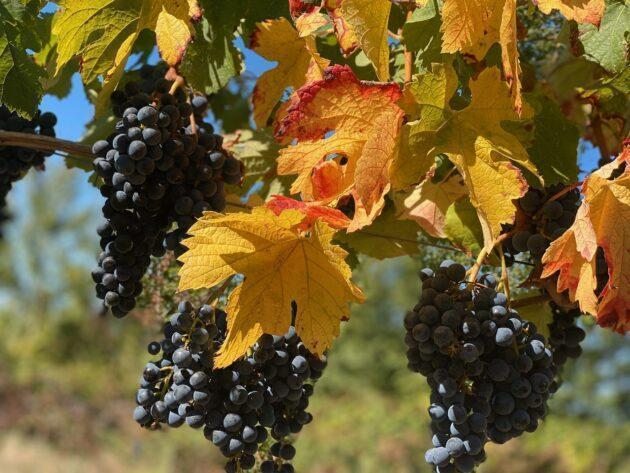
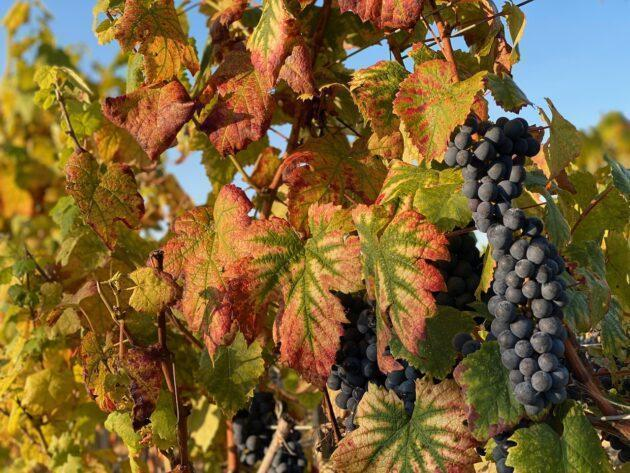
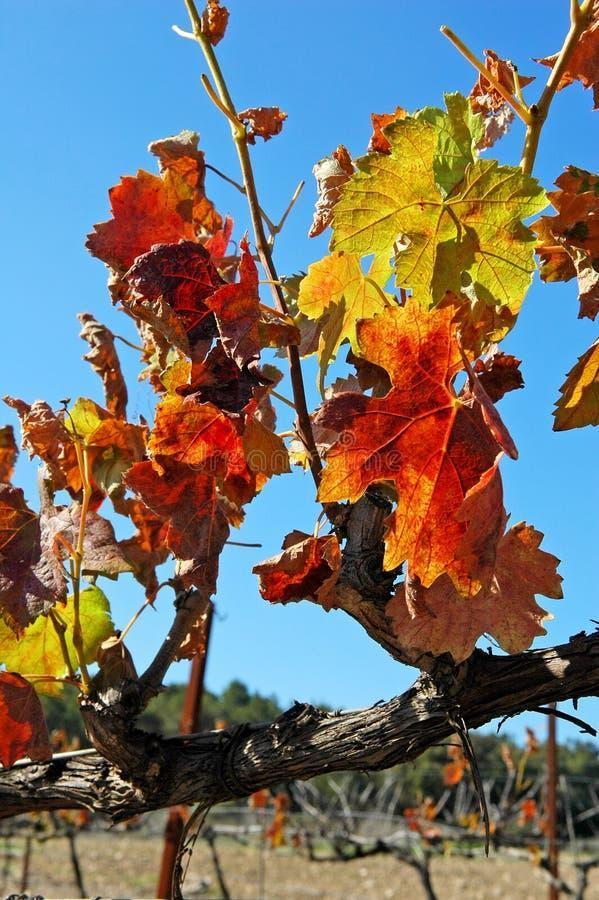
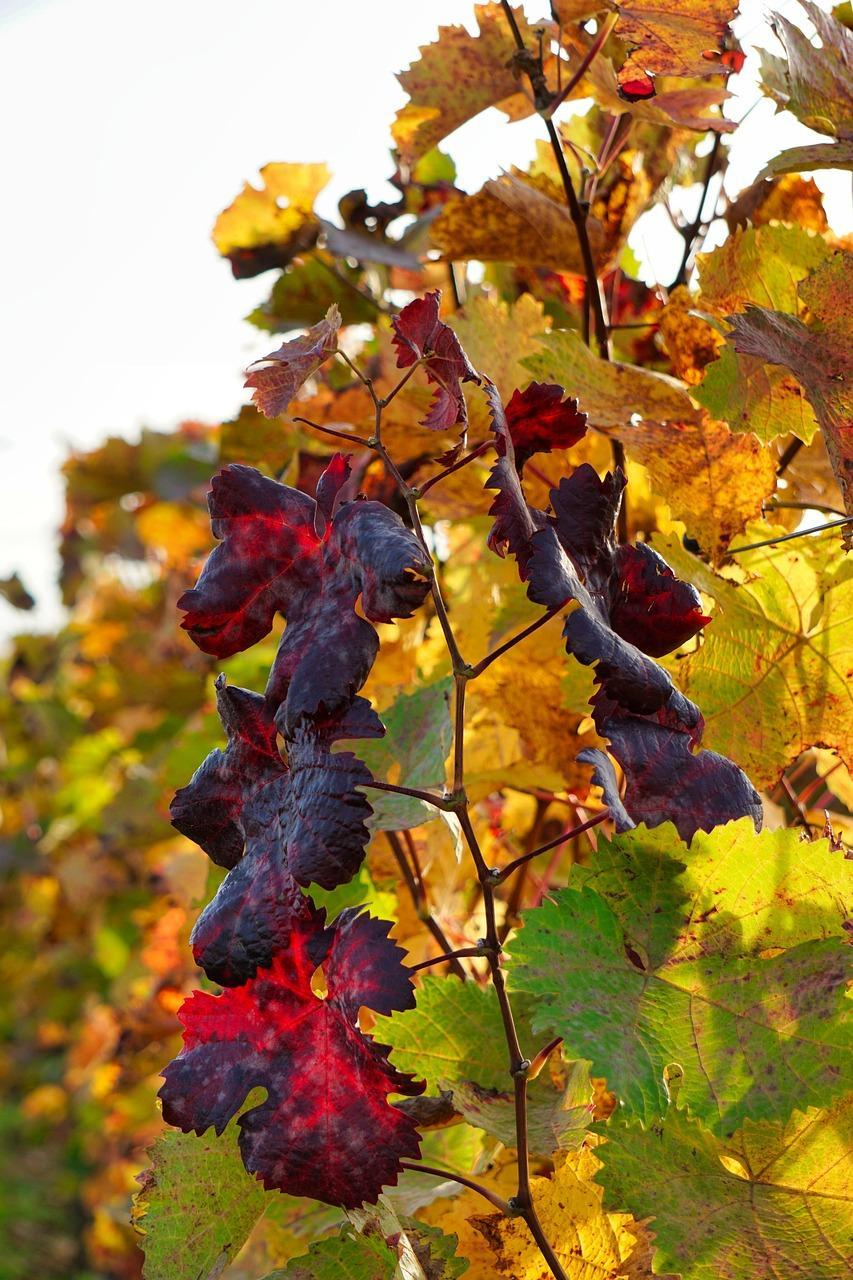
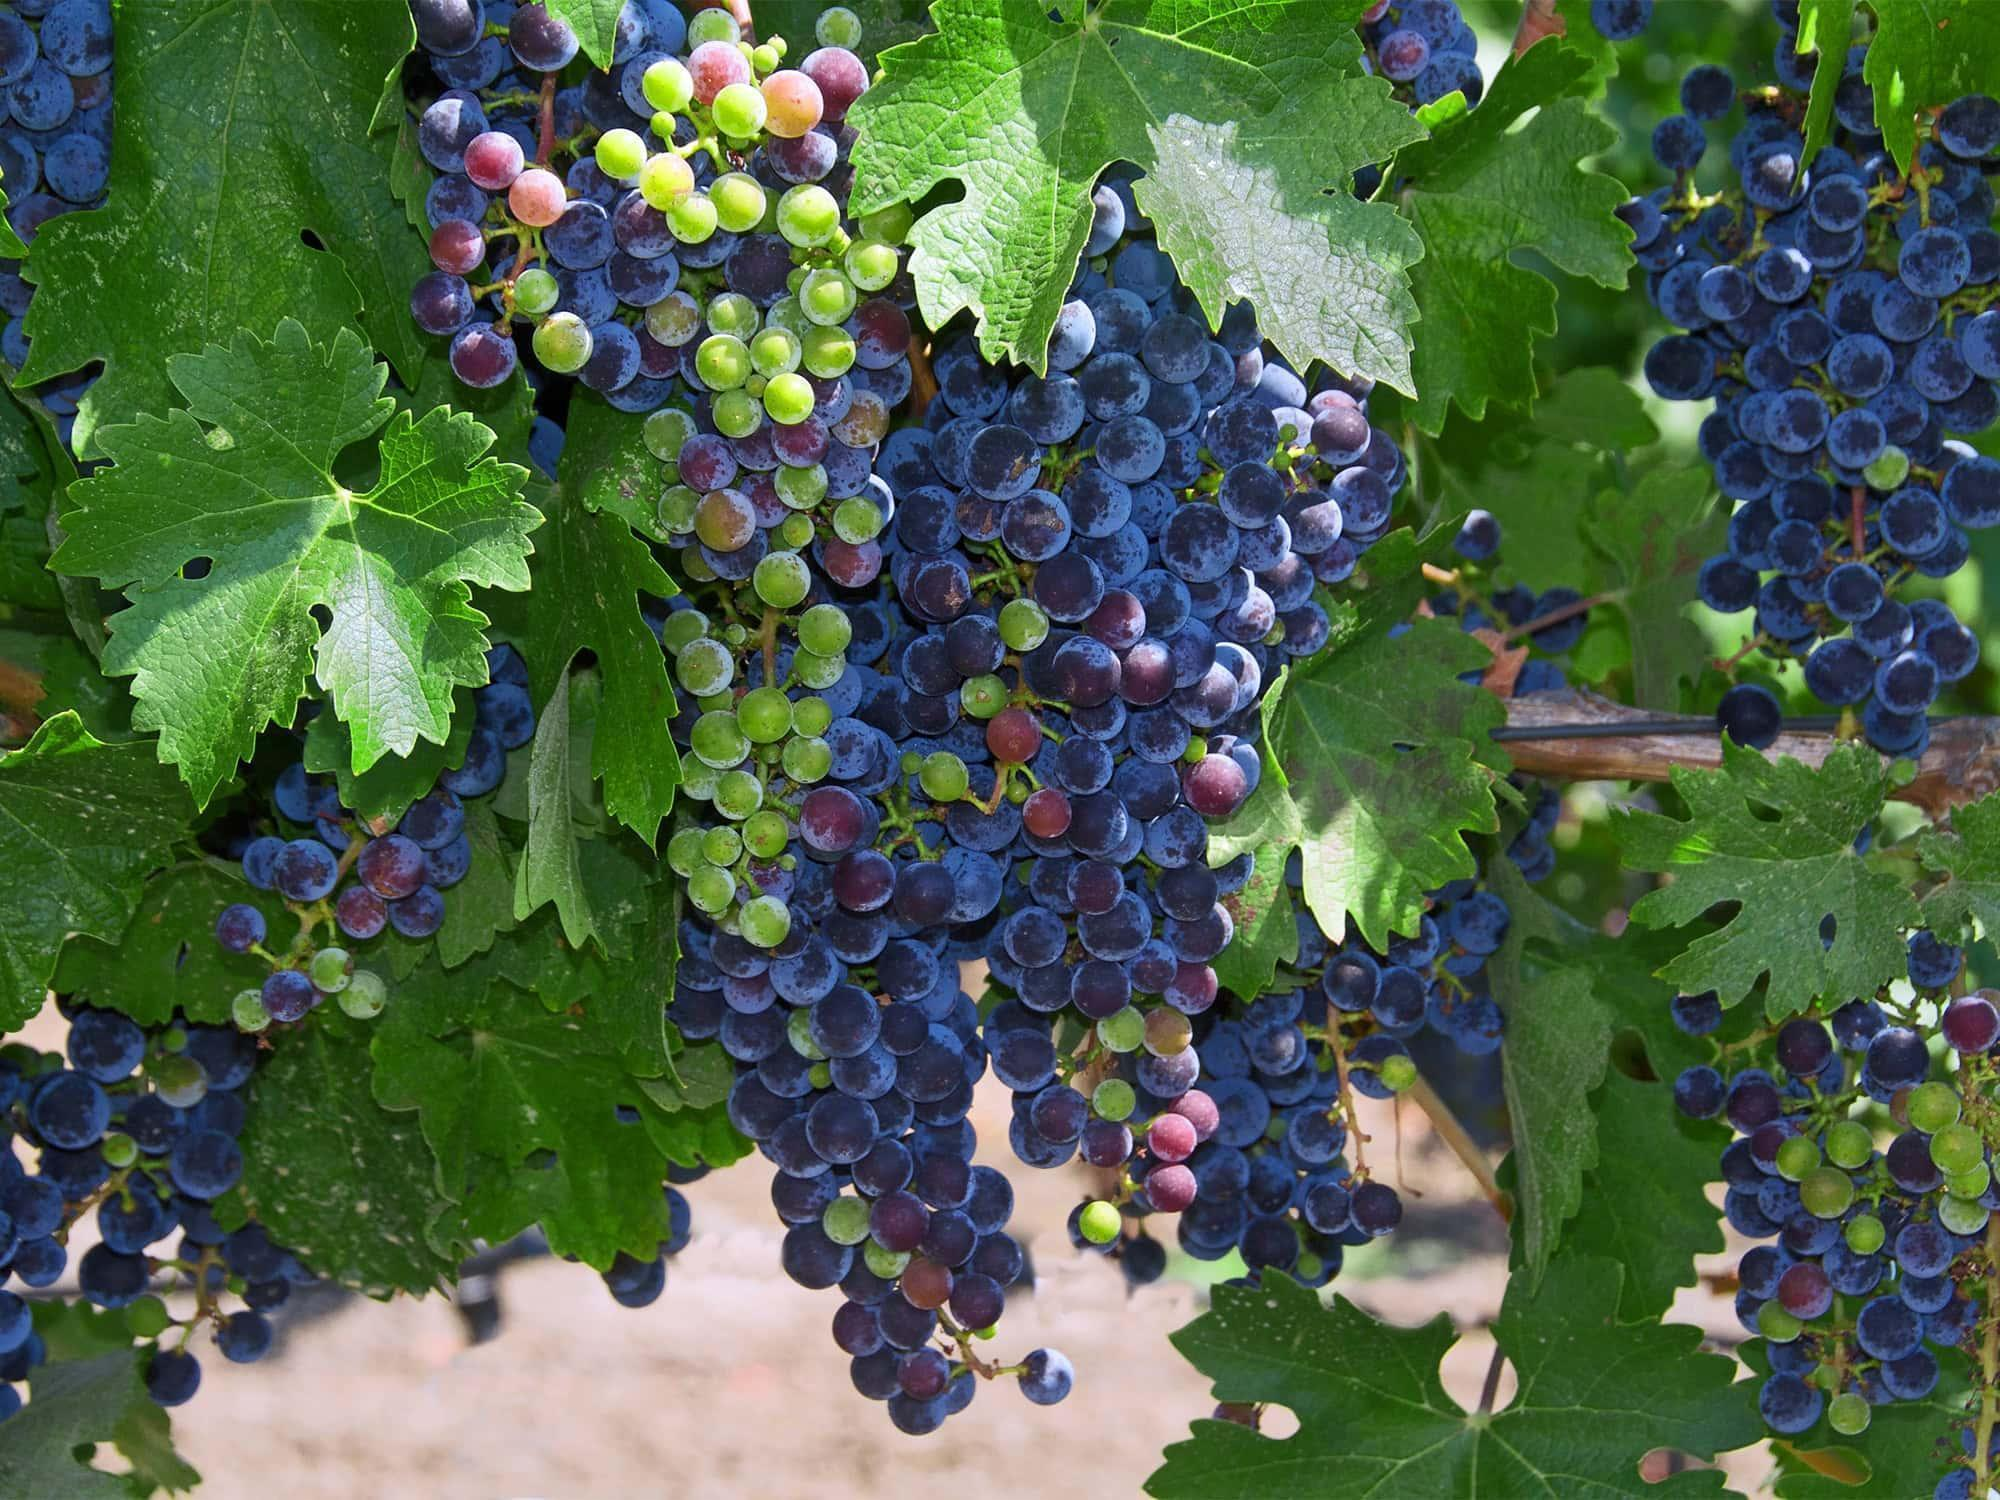
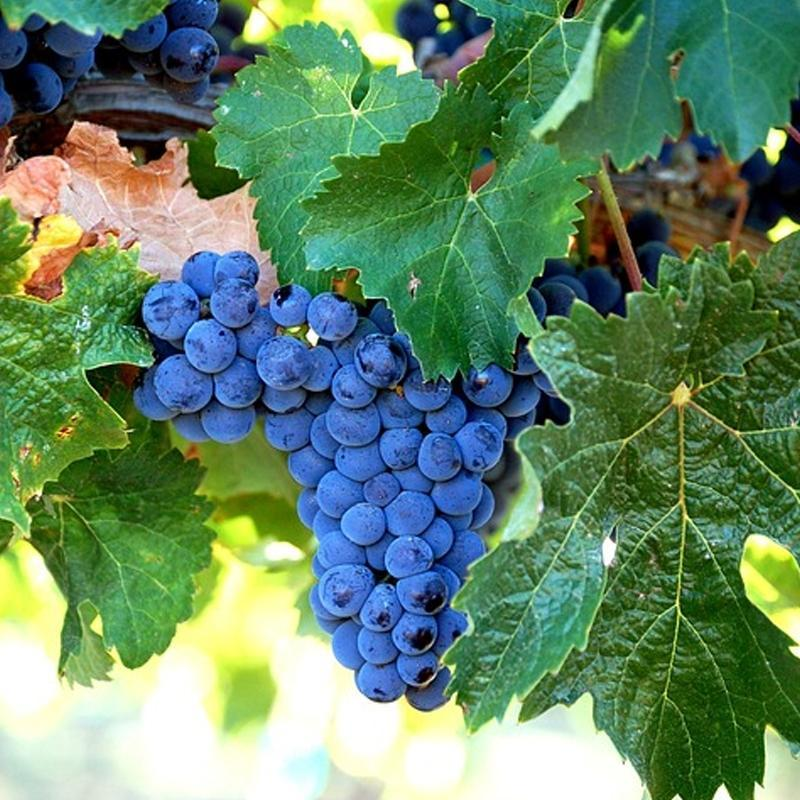
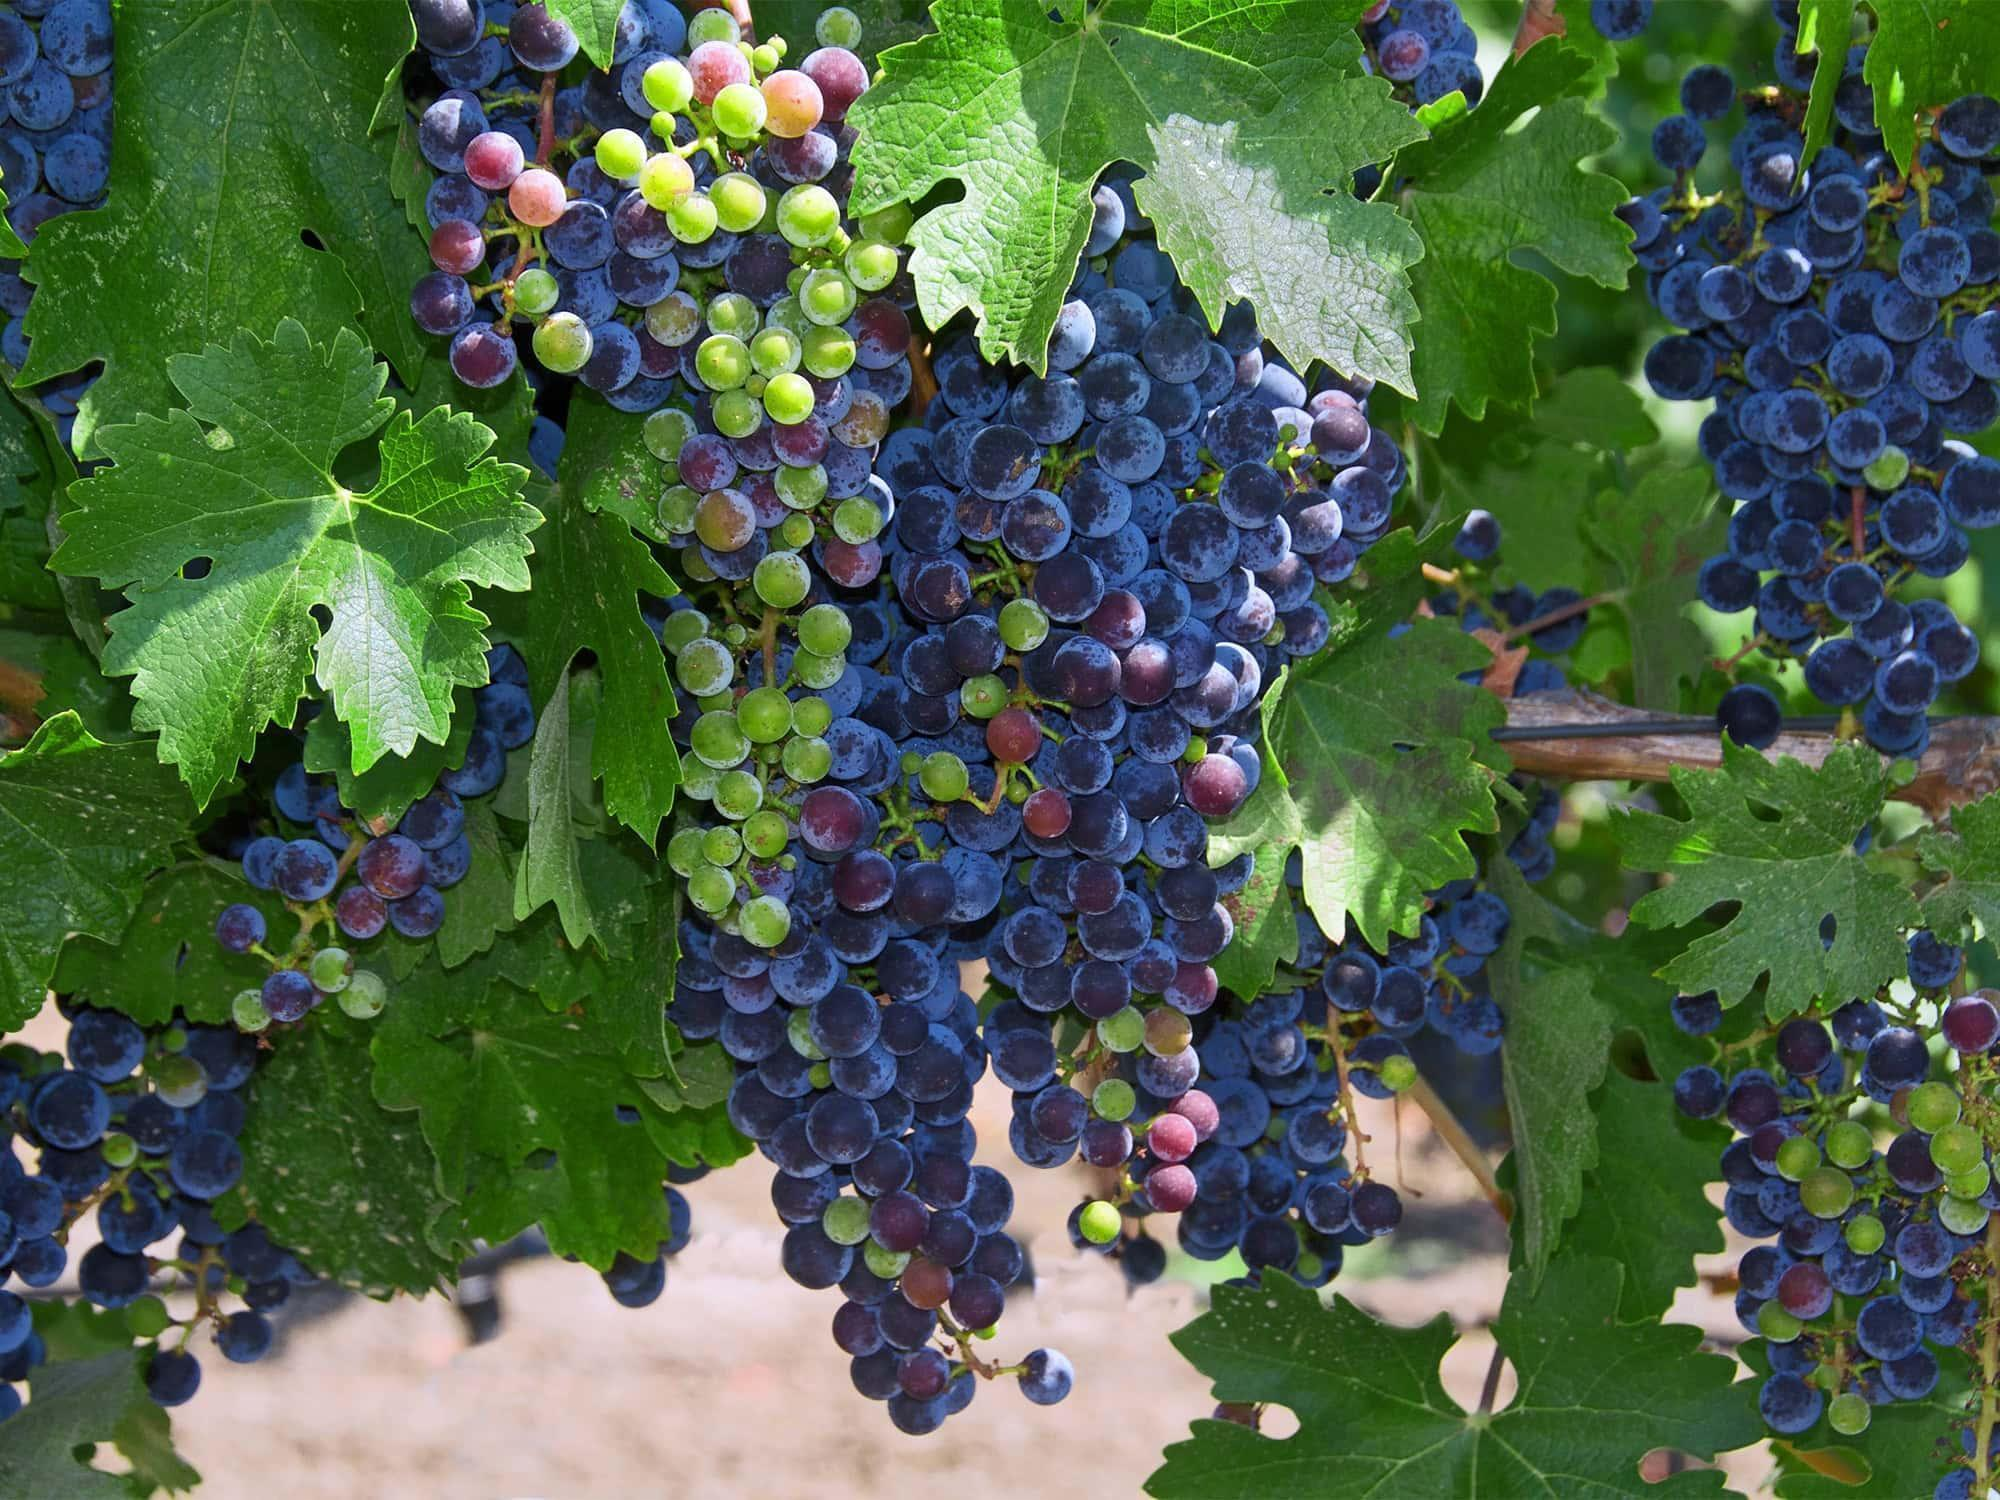
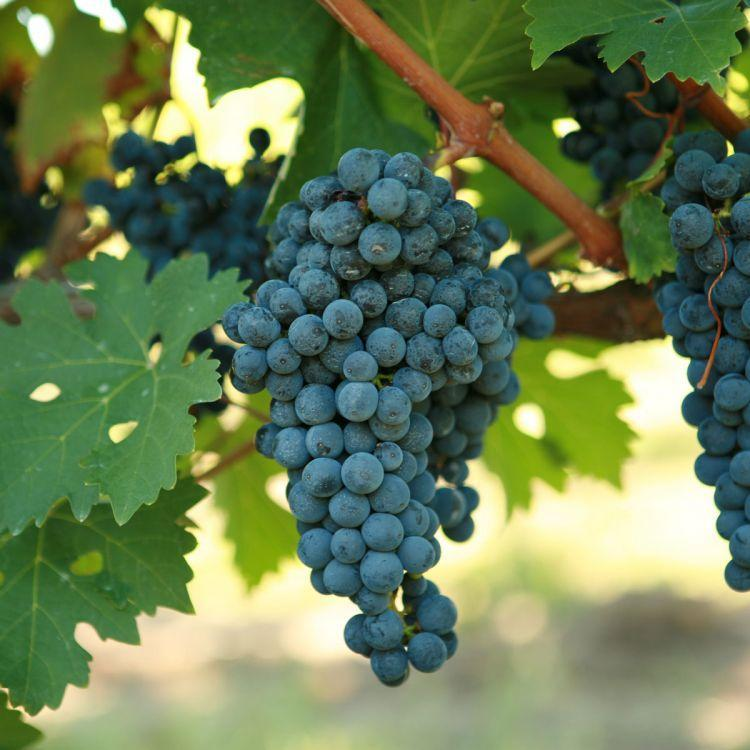
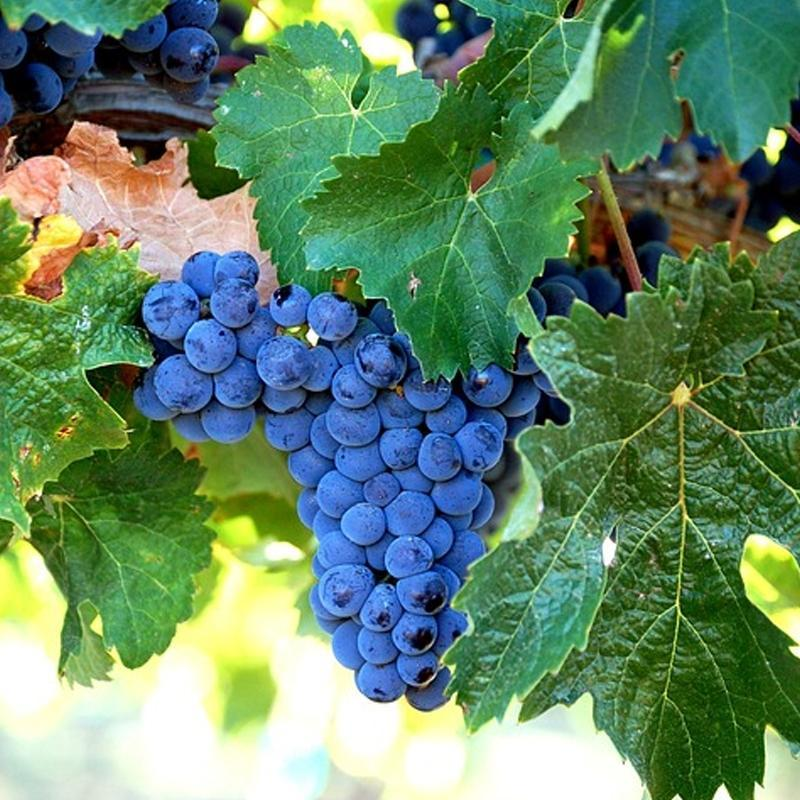
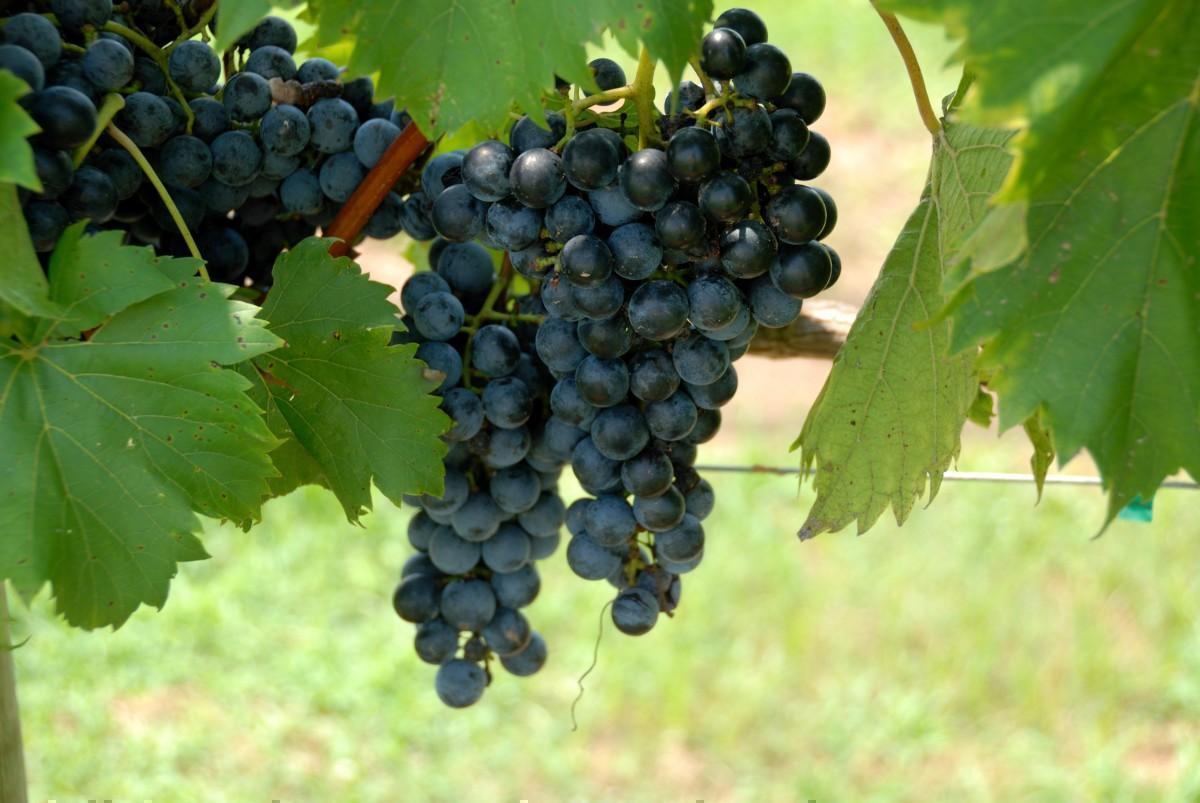
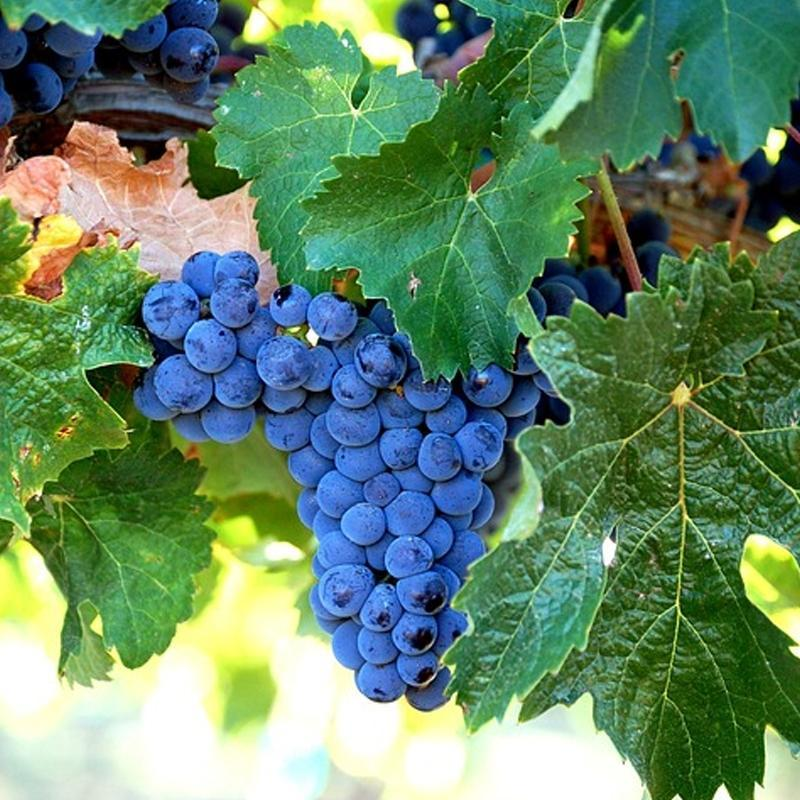
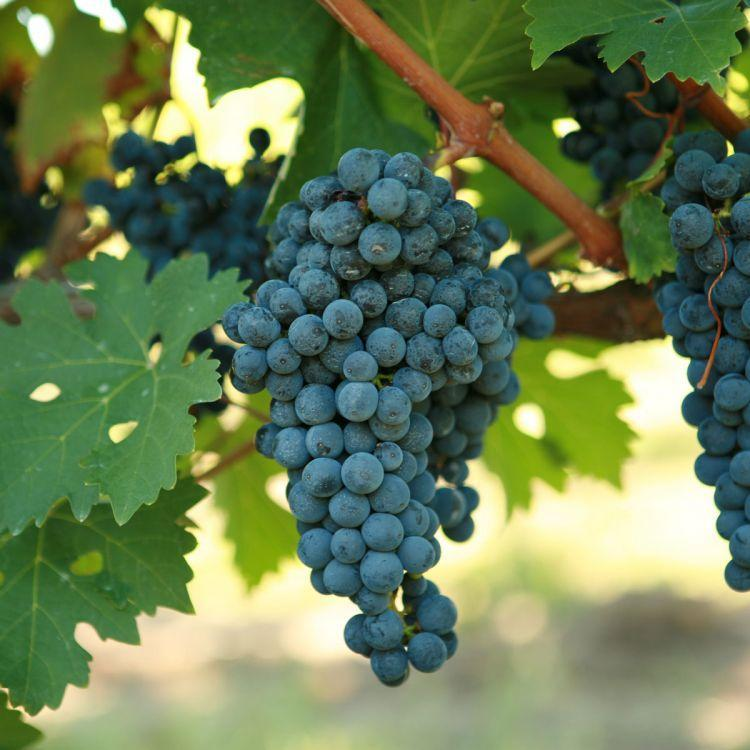
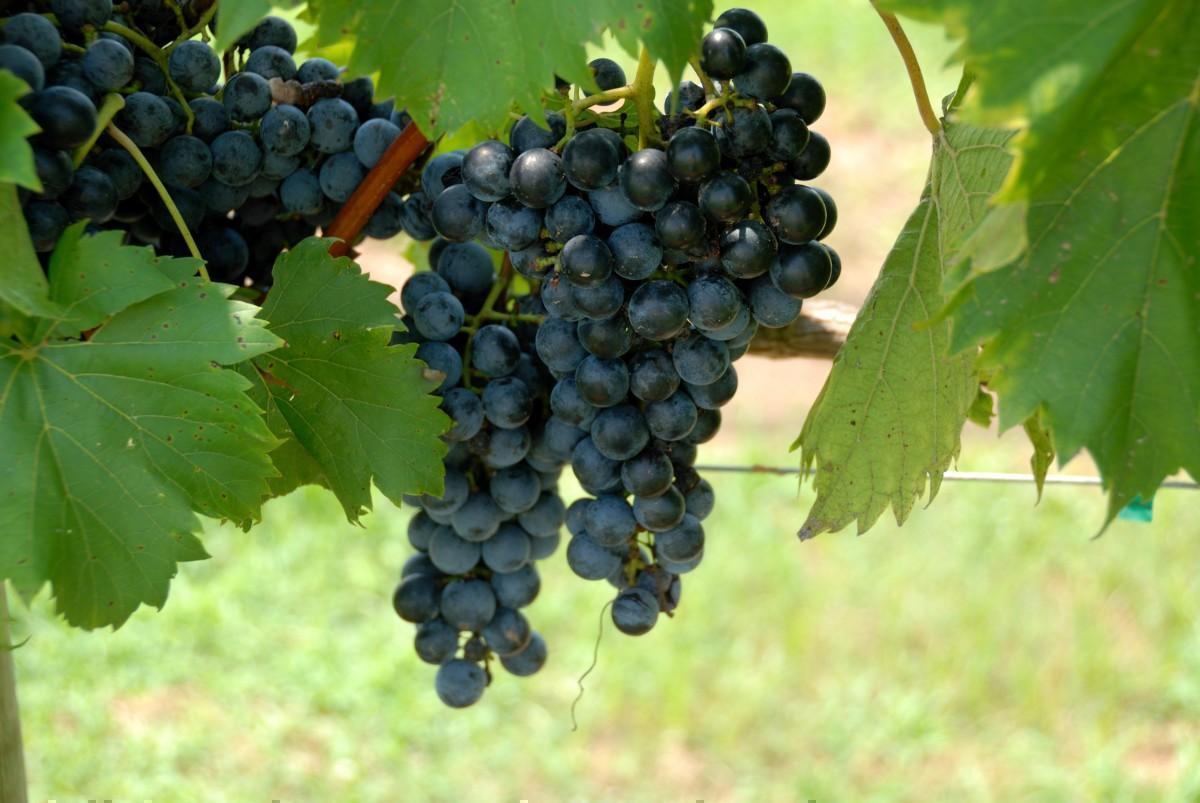
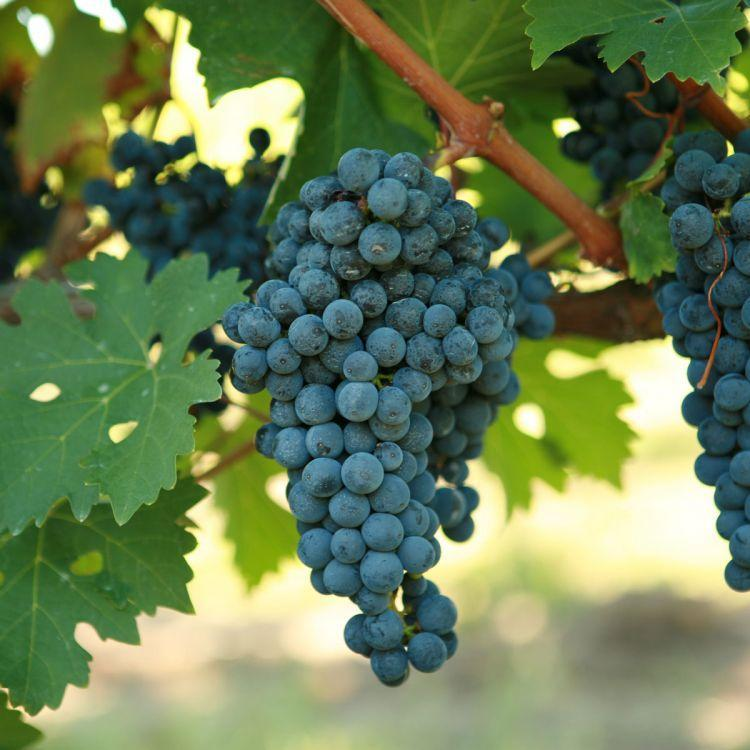
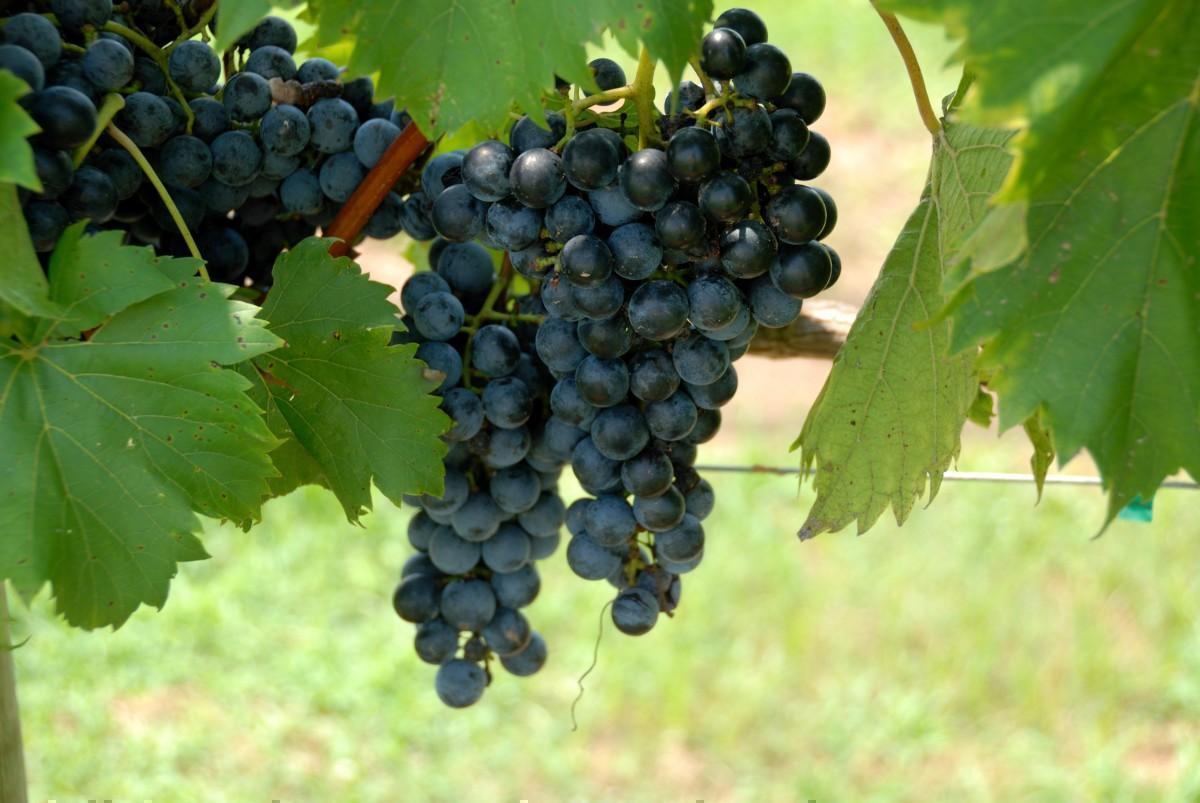
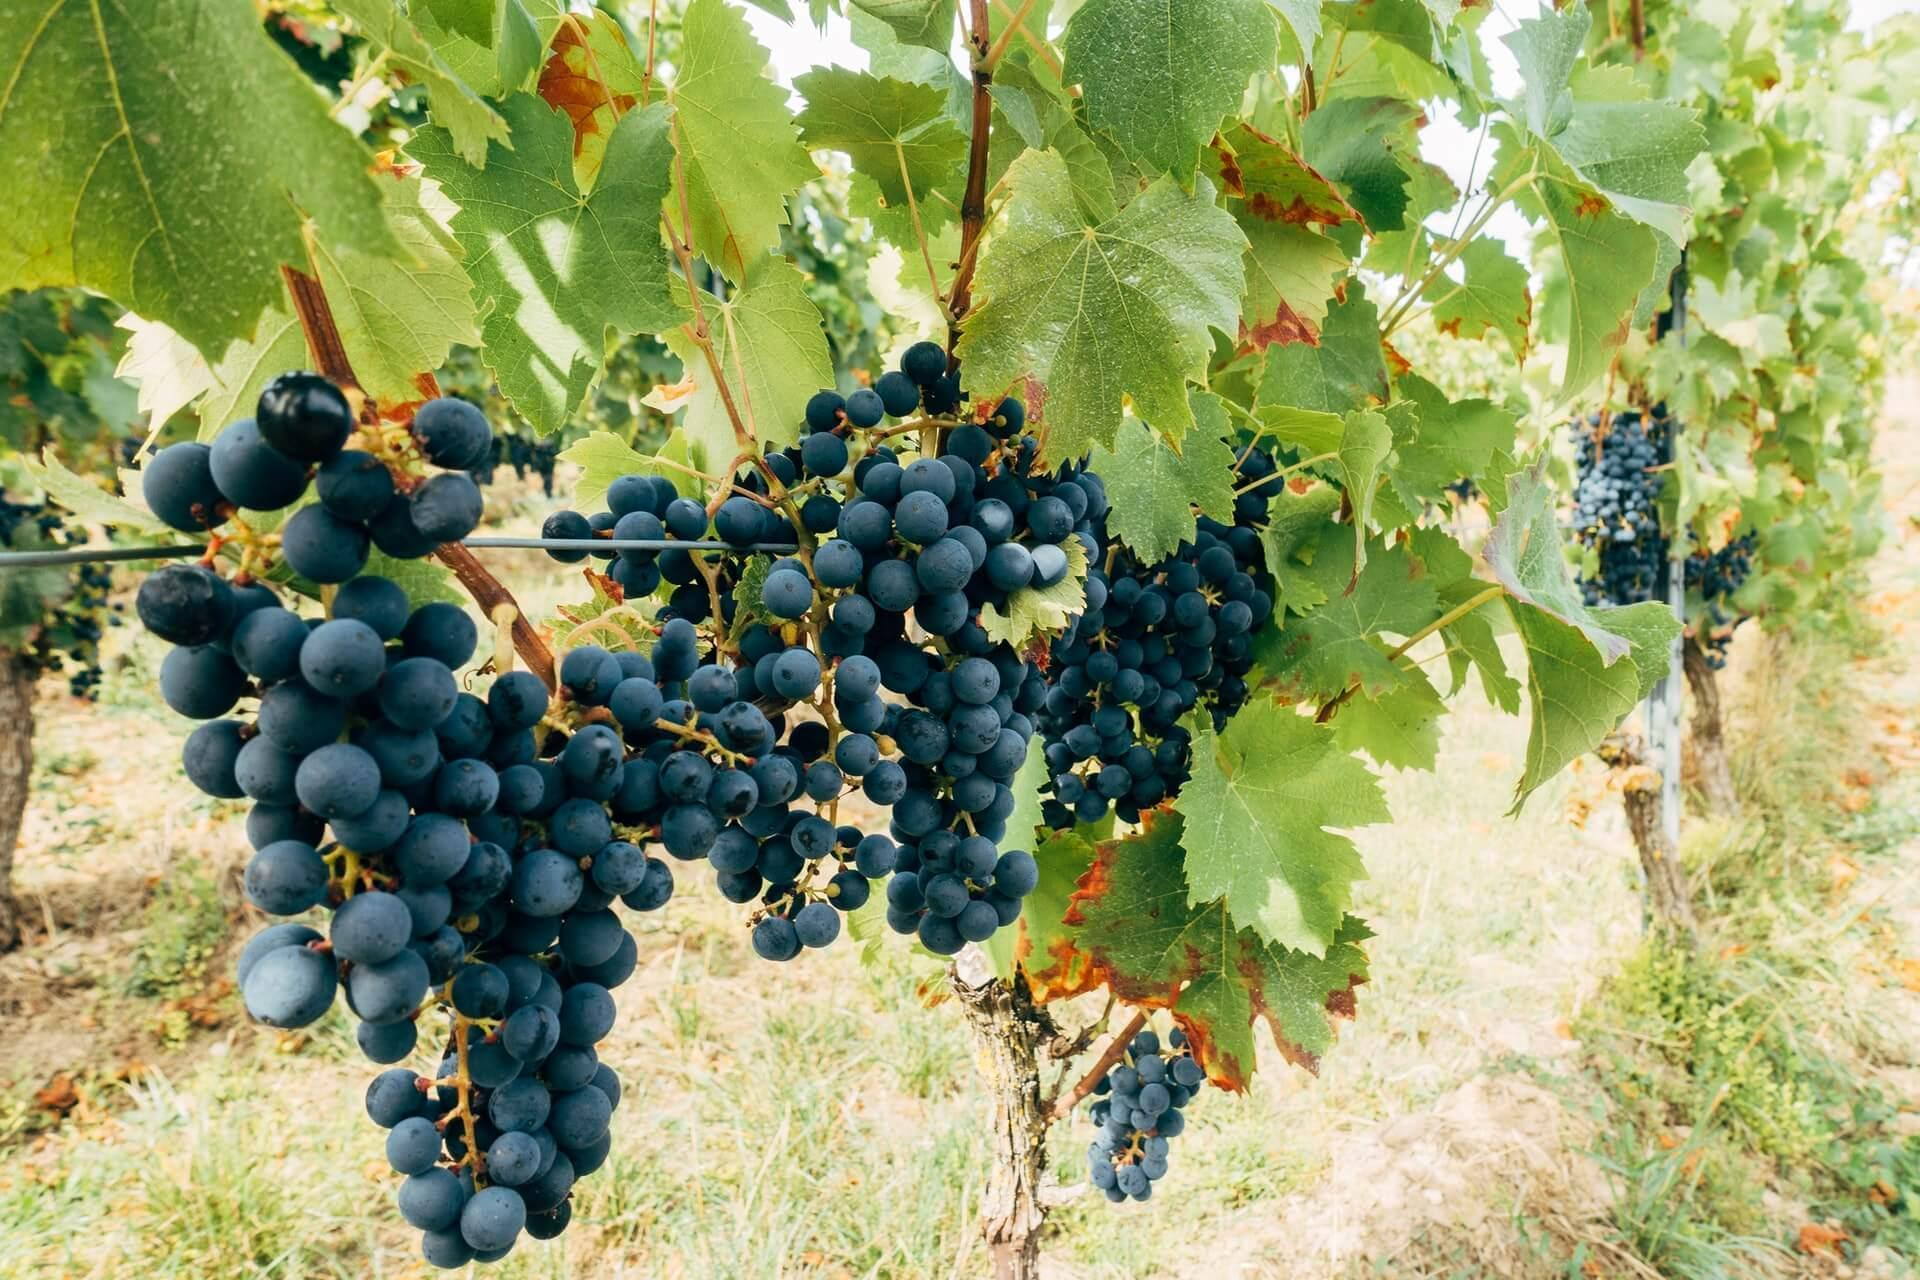
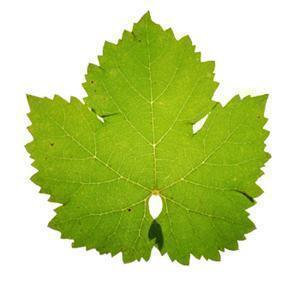
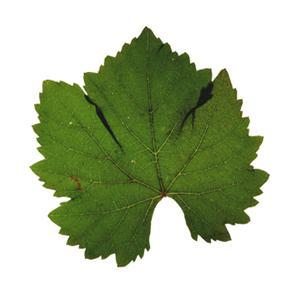
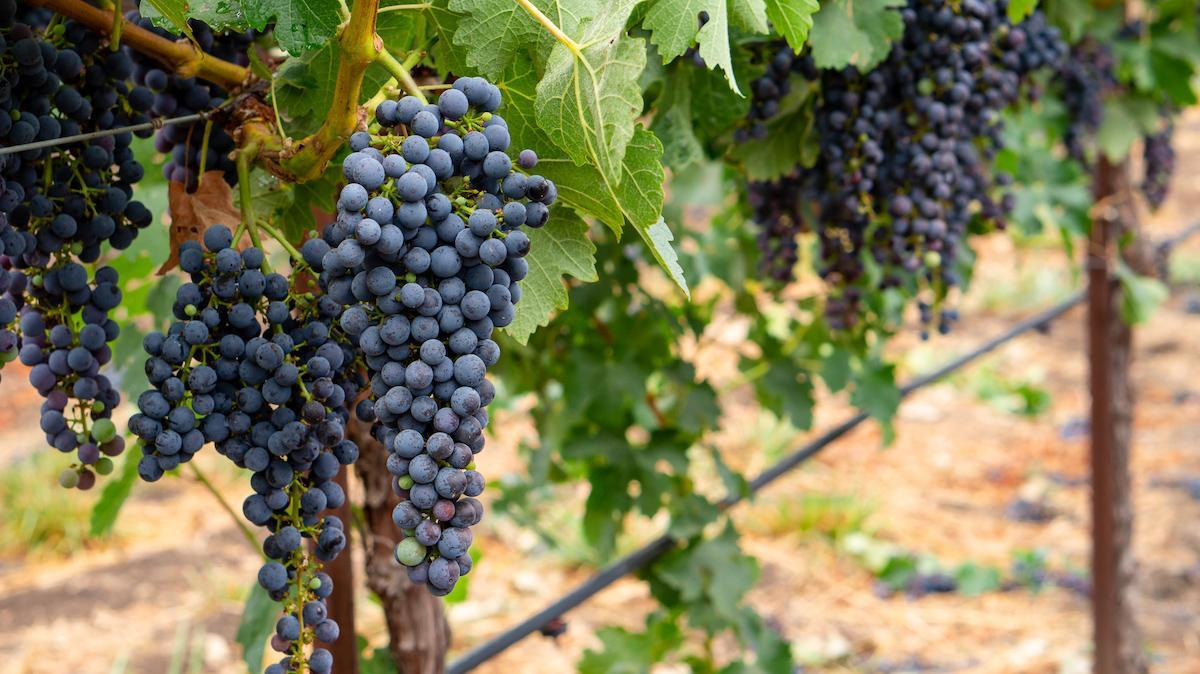
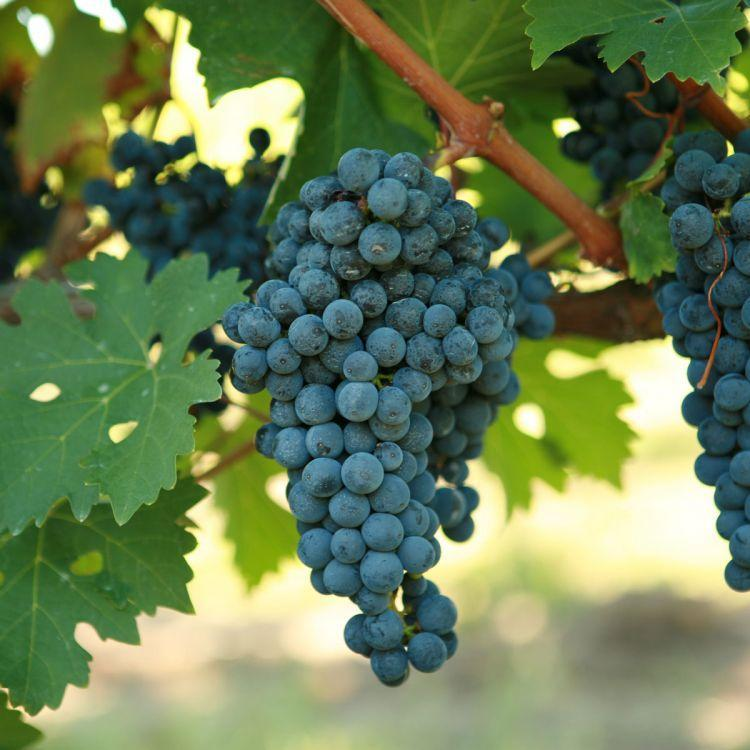

In [6]:
import pandas as pd
from IPython.display import display, HTML

def compare_pairwise_similarity(image_paths, image_embeddings):
    data = []
    for i, (path1, embeddings1) in enumerate(zip(image_paths, image_embeddings)):
        for j, (path2, embeddings2) in enumerate(zip(image_paths, image_embeddings)):
            if i < j:  # To avoid duplicate pairs and self-comparison
                similarity = cosine_similarity(embeddings1, embeddings2)
                data.append({"path1": path1, "path2": path2, "similarity": similarity})
    return data

def add_image_cell(image_path):
    try:
        src = image_base64(load_image(image_path))
        return f'<img src="{src}" width="100">'
    except:
        return ''

def display_df(df):
    display(HTML(df.to_html(escape=False)))

similarity_data = compare_pairwise_similarity(image_paths, image_embeddings)
similarity_df = pd.DataFrame(similarity_data)

for image_path in similarity_df[similarity_df['similarity'] > 0.98]['path2']:
    if image_path in image_paths:
        idx = image_paths.index(image_path)
        image_paths.pop(idx)
        image_embeddings.pop(idx)
        if os.path.exists(image_path):
            os.remove(image_path)

threshold = 0.96
similar_images = similarity_df[similarity_df['similarity'] > threshold].copy()

# Apply the function to the dataframe
df_similar = similar_images.head(50).copy()
df_similar['image1'] = df_similar['path1'].apply(add_image_cell)
df_similar['image2'] = df_similar['path2'].apply(add_image_cell)
display_df(df_similar)

In [7]:
data = [{"path": path, "vector": vector} for path, vector  in tqdm(zip(image_paths, image_embeddings))]
df = pd.DataFrame(data)

texts = [search_query]
text_embeddings = clip_model.get_text_embeddings(texts)[0]

df['score'] = df['vector'].apply(lambda x: cosine_similarity(x, text_embeddings))

df_filter = df[df['score'] < 0.25].sort_values('score', ascending=False)
df_filter['image'] = df_filter['path'].apply(add_image_cell)
display_df(df_filter[['path', 'score', 'image']])

294it [00:00, 283281.73it/s]


,path,score,image


In [8]:
for image_path in tqdm(df_filter['path']):
    if os.path.exists(image_path):
        os.remove(image_path)

0it [00:00, ?it/s]
